In [1]:
import numpy as np
import tensorflow as tf
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from collections import deque
import time
import random

from tqdm import tqdm
import os
from PIL import Image
import cv2
import pygame
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 20_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False
MOMENTS = 2

In [3]:
class snakeEnv():
   
    def __init__(self):
        self.actions = ['up','left','right','down','none']
        self.ACTION_SPACE_SIZE = len(self.actions)
        self.RES = 10
        self.SIZE = 1
        self.OBSERVATION_SPACE_VALUES = (self.RES//self.SIZE, self.RES//self.SIZE, MOMENTS) 
        self.states = []

        self.reset()

    def reset(self):
        self.length = 1
        self.dirs = {'W': True, 'S': True, 'A': True, 'D': True, }
        self.x, self.y = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
        self.apple = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
        self.snake = [(self.x, self.x)]
        self.dx, self.dy = 0, 0
        self.states = [self.getState()]*MOMENTS
        return np.array(self.states[-MOMENTS:]).reshape(self.RES,self.RES,MOMENTS)
        
        
    def step(self, id_action):
        reward = 0
        terminated = False
        init_dist = np.linalg.norm(np.array(env.snake[-1]) -np.array(env.apple))
        
        
        if self.actions[id_action]=='up':
            if self.dirs['W']:
                self.dx, self.dy = 0, -1
                self.dirs = {'W': True, 'S': False, 'A': True, 'D': True, }
        elif self.actions[id_action]=='down':
            if self.dirs['S']:
                self.dx, self.dy = 0, 1
                self.dirs = {'W': False, 'S': True, 'A': True, 'D': True, }
        elif self.actions[id_action]=='left':
            if self.dirs['A']:
                self.dx, self.dy = -1, 0
                self.dirs = {'W': True, 'S': True, 'A': True, 'D': False, }
        elif self.actions[id_action]=='right':
            if self.dirs['D']:
                self.dx, self.dy = 1, 0
                self.dirs = {'W': True, 'S': True, 'A': False, 'D': True, }
        elif self.actions[id_action]=='none':
            reward += 0.1
                
        self.x += self.dx * self.SIZE
        self.y += self.dy * self.SIZE
        
        if self.length>1:
            self.snake.append((self.x, self.y))
            self.snake = self.snake[-self.length:]
        else:
            self.snake = [(self.x,self.y)]

        
        if self.snake[-1] == self.apple:
            reward += 20
            self.apple = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
            self.length += 1

        if self.x < 0 or self.x > self.RES - self.SIZE or self.y < 0 or self.y > self.RES - self.SIZE or len(self.snake) != len(set(self.snake)):
            reward += -20
            terminated = True
                
        final_dist = np.linalg.norm(np.array(env.snake[-1]) -np.array(env.apple))
                
        observation = self.get_image()
        reward += (init_dist - final_dist)*2
        
        self.states.append(observation)
        
        return np.array(self.states[-MOMENTS:]).reshape(self.RES,self.RES,MOMENTS), reward, terminated

#     def getStateArr(self, d,sz, snk, app):
#         res = np.zeros((int(sz/d),int(sz/d)))
#         res[min(int( (app[0])/d),int(sz/d)-1 )][min(int( (app[1])/d),int(sz/d)-1)] = 0.5
#         for i in  range(len(snk)):
#             res[min(int( (snk[i][0])/d),int(sz/d)-1)][min(int( (snk[i][1])/d),int(sz/d)-1)] = 1
#         return np.array([res.T]).reshape((self.RES//self.SIZE,self.RES//self.SIZE,1))
    
    def getState(self):
        return self.get_image()
    
    def render(self, save = False, name = '1'):
        print()
        if save:
            img = Image.fromarray(self.states[-1].reshape((self.RES,self.RES))).resize((1000,1000), Image.BOX)
            img.save('games/'+name+'.jpg')
        plt.imshow(self.states[-1].reshape((self.RES,self.RES)), cmap='gray', vmin=0, vmax=255)
        plt.show()
        
    def get_image(self):
        img = Image.new("RGB", (self.RES, self.RES))
        draw = ImageDraw.Draw(img)
        buf_size = 0 if self.SIZE == 1 else self.SIZE

        if len(self.snake)>1:
            for i, j in self.snake:
                draw.rectangle( [(i, j), (buf_size + i, buf_size + j)], fill = 'white')
        else:            
            for i, j in self.snake:
                draw.rectangle([ (self.snake[0][0], self.snake[0][1]), (buf_size +  self.snake[0][0], buf_size +  self.snake[0][1])], fill = 'white') 


        draw.rectangle([ (self.apple[0], self.apple[1]), (buf_size +  self.apple[0], buf_size +  self.apple[1])], fill = 'grey') 

        state_pic = np.array(img.convert("L"))


        return state_pic.reshape((self.RES,self.RES,1))

(10, 10, 1)



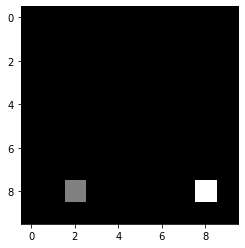

In [4]:
env = snakeEnv()
print(env.get_image().shape)
env.render()

In [9]:
ep_rewards = [-200]

random.seed(1)
np.random.seed(1)


if not os.path.isdir('models'):
    os.makedirs('models')


class ModifiedTensorBoard(TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    def set_model(self, model):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    def on_batch_end(self, batch, logs=None):
        pass

    def on_train_end(self, _):
        pass

    def update_stats(self, **stats):
        self._write_logs(stats, self.step)
        
    def _write_logs(self, logs, index):
        for name, value in logs.items():
            tf.summary.scalar(name, value)
            self.step += 1
            self.writer.flush()   

            
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(128, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  

        
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(16))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
       # print(minibatch[0].shape)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)


        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, 
                       callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
            
            
    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


In [10]:
agent = DQNAgent()
agent.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 8, 8, 128)         2432      
_________________________________________________________________
activation_8 (Activation)    (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 128)         147584    
_________________________________________________________________
activation_9 (Activation)    (None, 2, 2, 128)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 128)        

In [11]:
# from tensorflow import keras
# mdl = keras.models.load_model('models/best.model')
# agent.model = mdl

In [12]:
import warnings
warnings.simplefilter("ignore")

In [13]:

MEAN_REWARD = -100
reward_hist = []
for episode in range(1, EPISODES + 1):
    agent.tensorboard.step = episode

    episode_reward = 0
    step = 1

    current_state = env.reset()

    done = False
    while not done:

        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs(current_state))
        else:
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        episode_reward += reward
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
        
    reward_hist.append( episode_reward )
    if episode > 100 and episode % 50 ==0:    
        MEAN_REWARD_PREV =  np.mean(reward_hist[-100:-50])
        MEAN_REWARD =  np.mean(reward_hist[-50:])
        if MEAN_REWARD > MEAN_REWARD_PREV:
            agent.model.save('models/best.model')
        print(episode, MEAN_REWARD)
#         env.render()
    

    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)


        
    MEAN_REWARD_PREV =  np.mean(reward_hist[-50:])
    
    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)


150 -23.24660422114865
200 -22.796578366871195
250 -24.508180138785377
300 -23.515308944923916
350 -22.23229698292629
400 -23.305918578760785
450 -20.359806785950628
500 -20.180334255103247
550 -21.937147263653234
600 -21.513886285226008
650 -23.158044029928472
700 -21.467915728780177
750 -23.13384018309287
800 -23.445049648673194
850 -20.98685330436451
900 -21.755534392957678
950 -22.877103040949905
1000 -20.868383365525688
1050 -21.377338675108803
1100 -20.944225833709858
1150 -22.49248652095456
1200 -21.68307181852077
1250 -19.892833138303473
1300 -22.63034644454076
1350 -21.69630885494548
1400 -21.990289723044427
1450 -19.46058977232218
1500 -19.293840623990103
1550 -19.40180004960219
1600 -20.508000587338003
1650 -21.748330904957555
1700 -22.69508130472651
1750 -20.45460460283914
1800 -22.43652997097677
1850 -21.102695967779546
1900 -16.743519752635972
1950 -18.737057635433185
2000 -16.95596713834676
2050 -18.568249107619682
2100 -17.419695088676654
2150 -20.67567941057512
2200 -2

KeyboardInterrupt: 

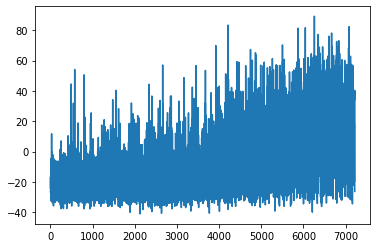

In [14]:
plt.plot(range(0,episode-1), reward_hist)
plt.show()

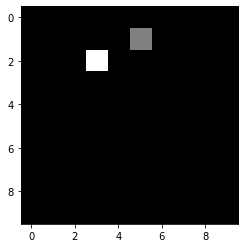

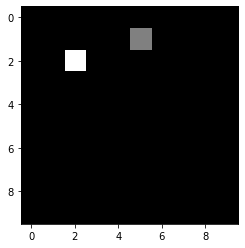

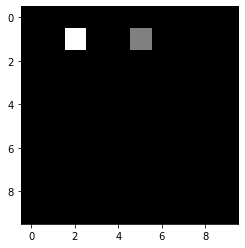

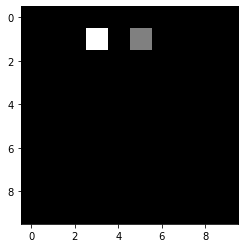

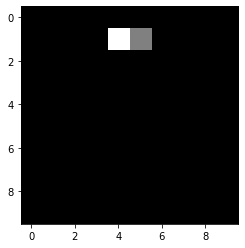

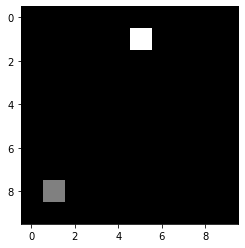

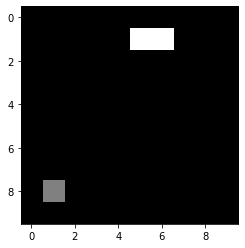

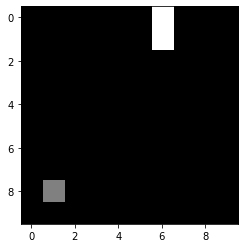

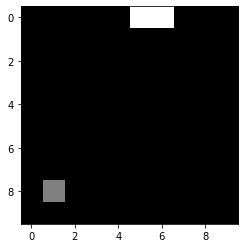

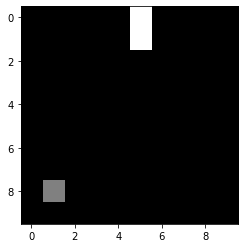

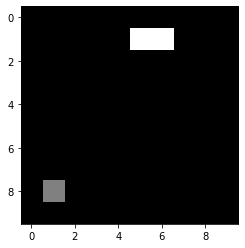

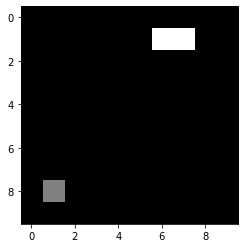

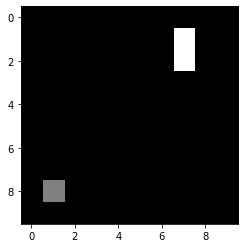

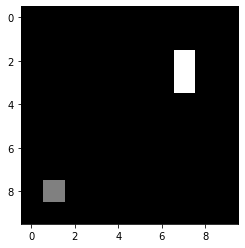

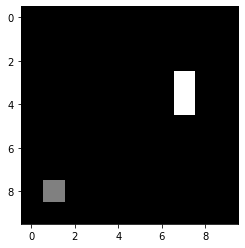

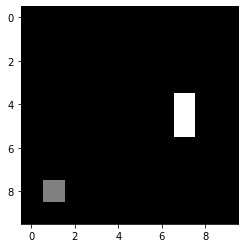

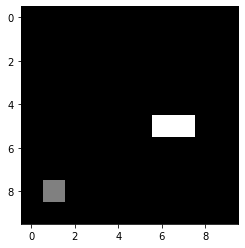

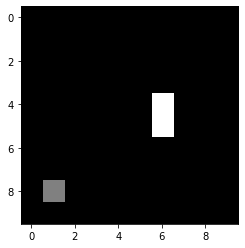

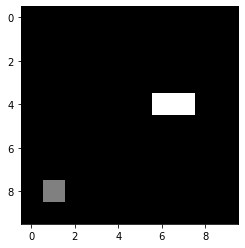

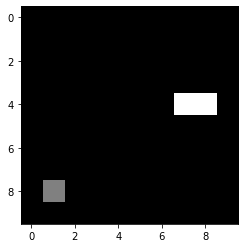

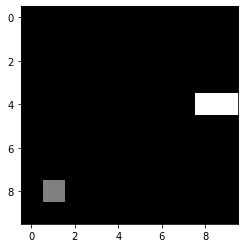

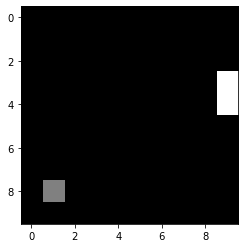

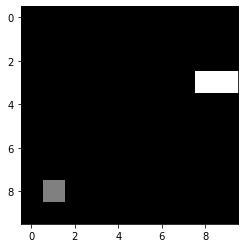

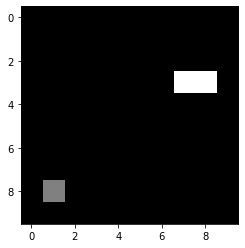

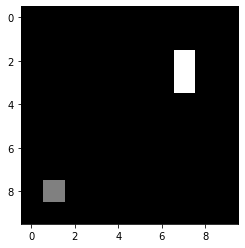

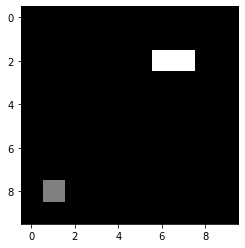

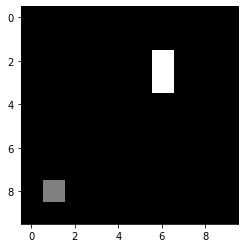

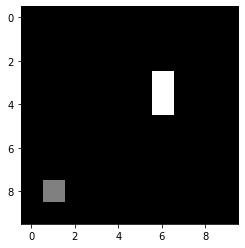

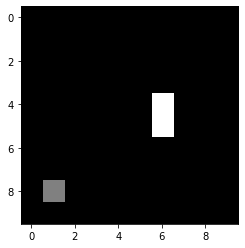

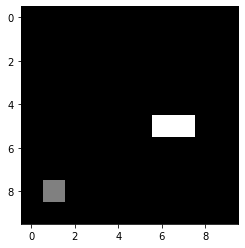

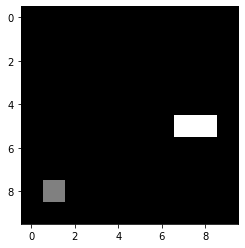

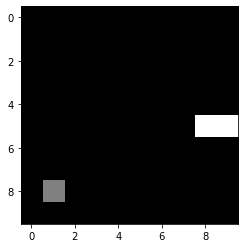

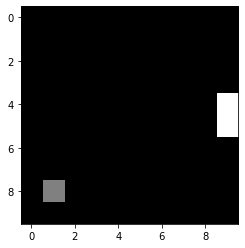

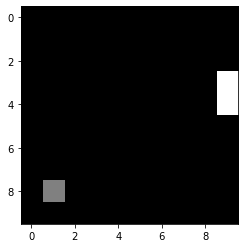

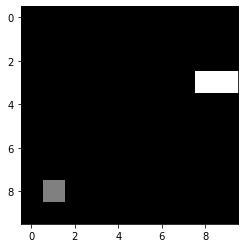

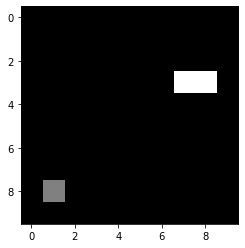

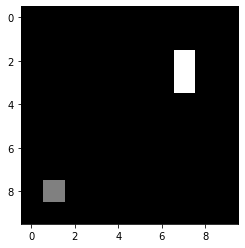

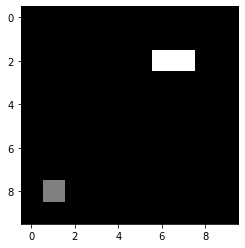

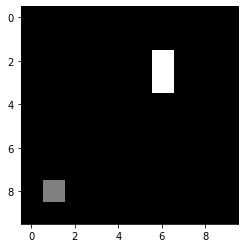

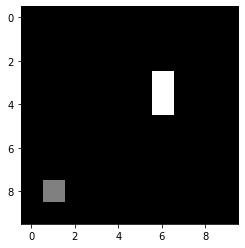

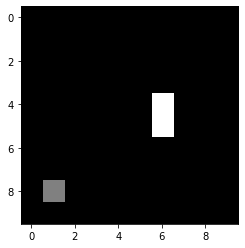

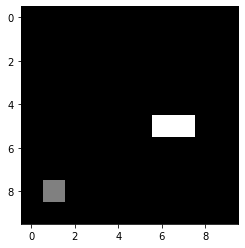

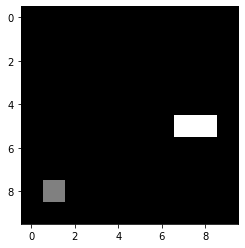

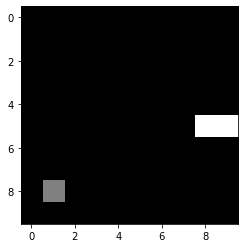

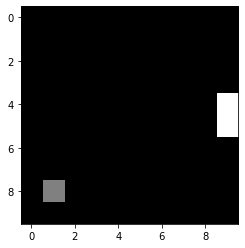

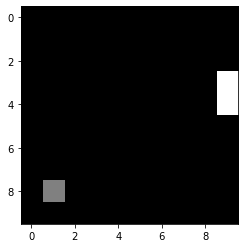

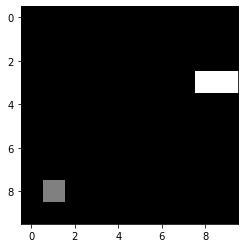

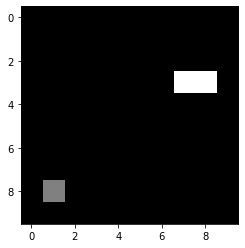

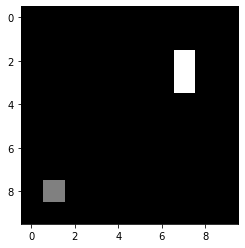

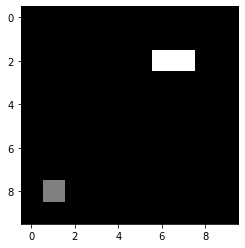

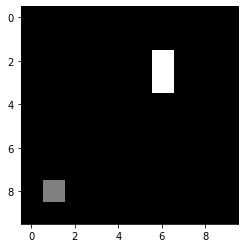

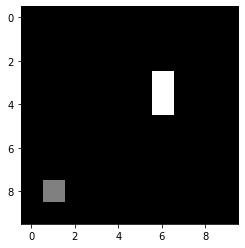

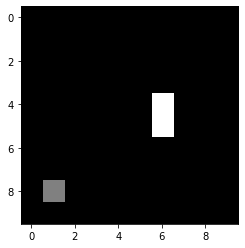

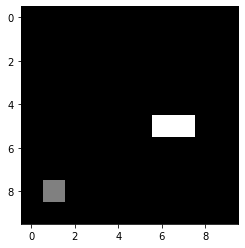

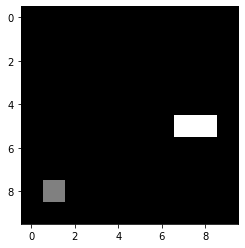

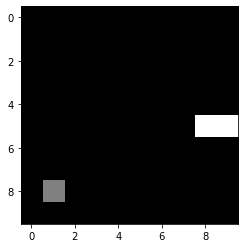

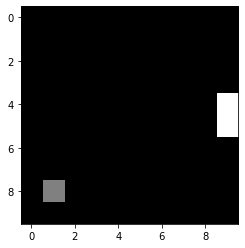

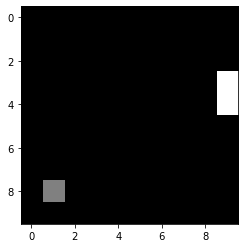

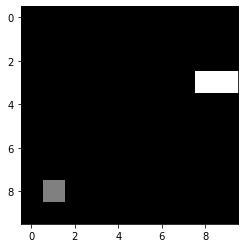

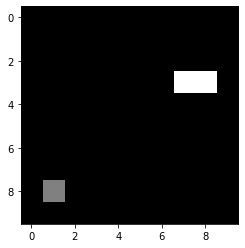

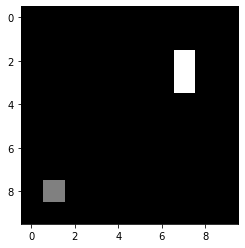

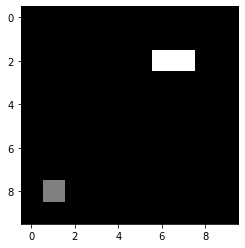

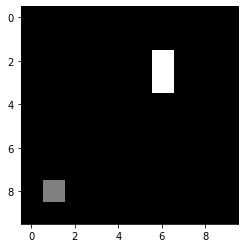

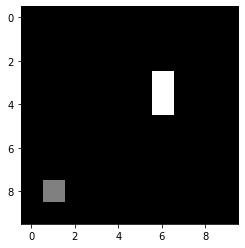

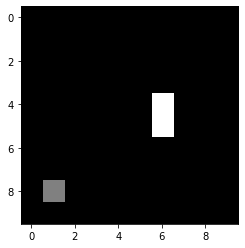

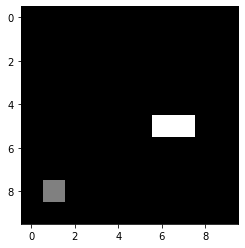

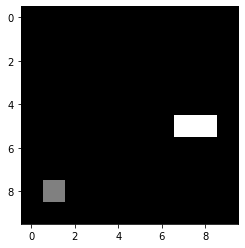

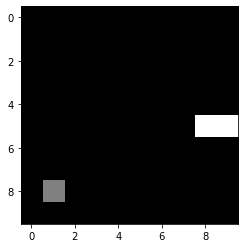

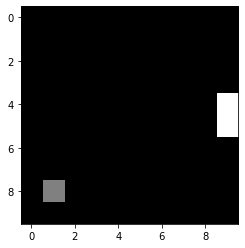

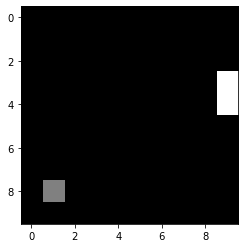

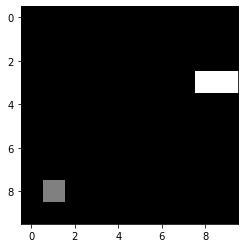

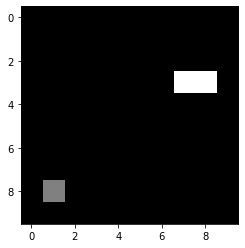

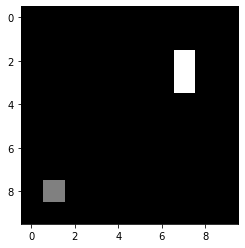

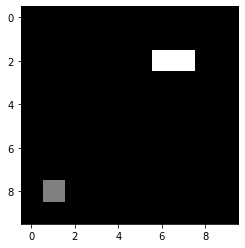

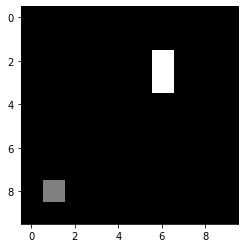

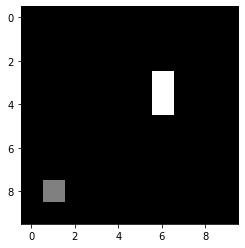

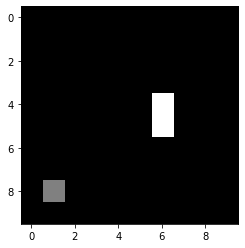

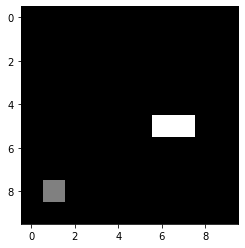

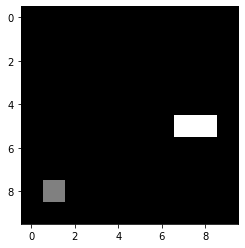

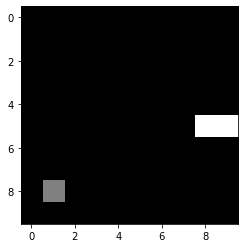

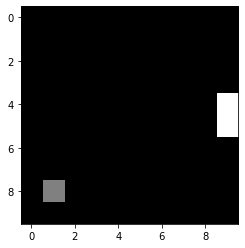

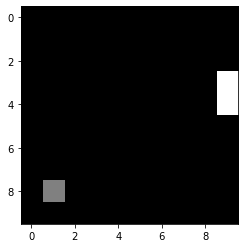

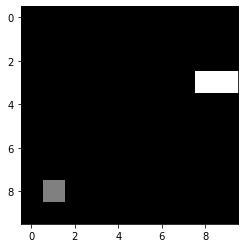

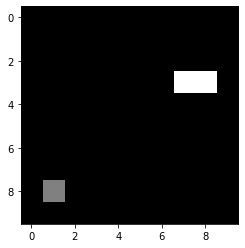

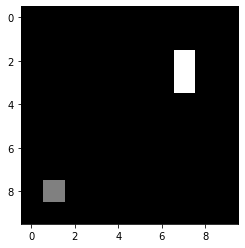

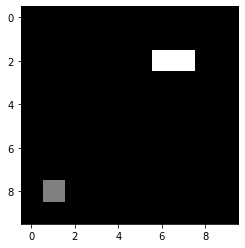

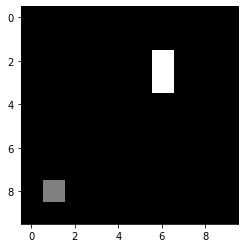

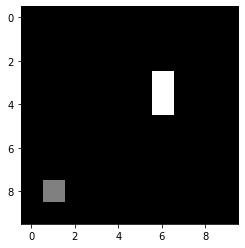

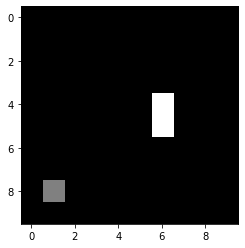

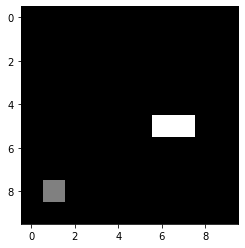

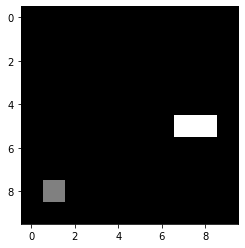

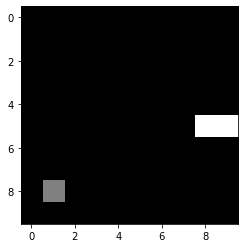

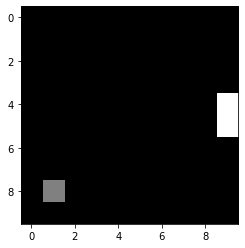

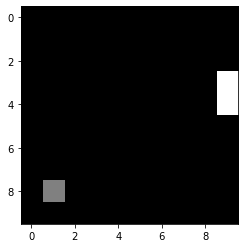

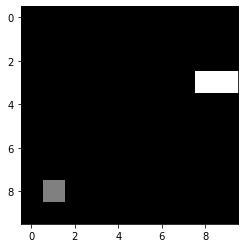

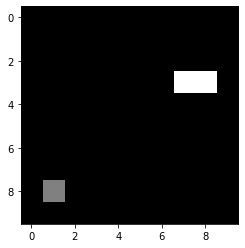

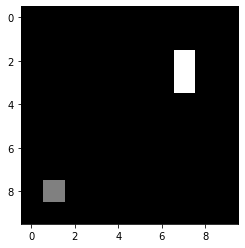

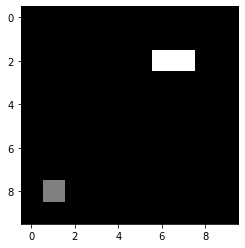

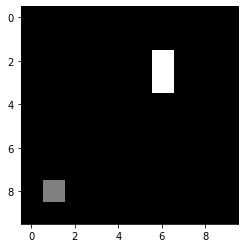

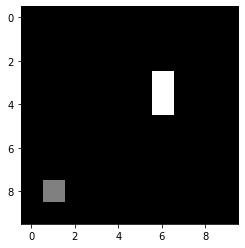

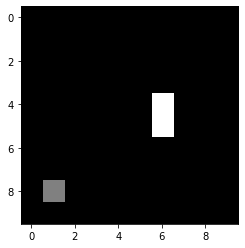

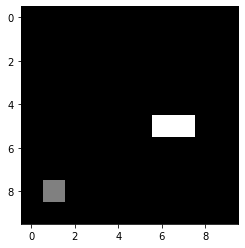

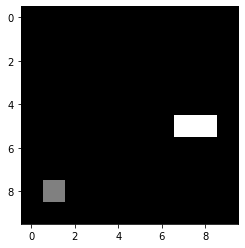

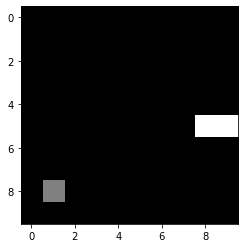

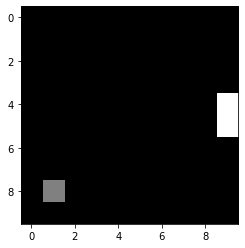

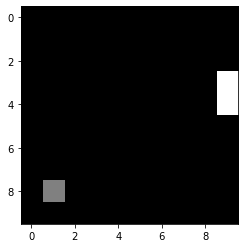

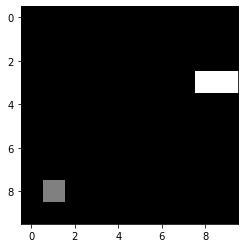

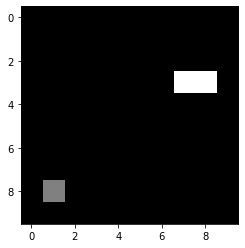

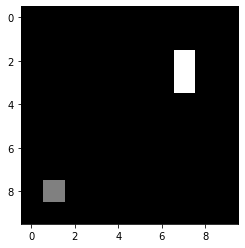

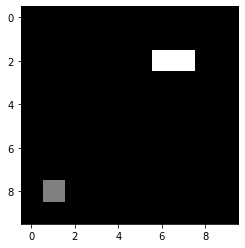

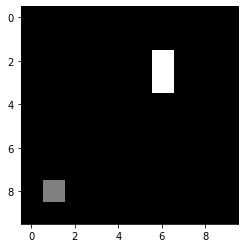

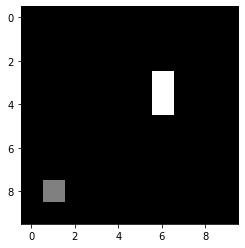

KeyboardInterrupt: 

In [21]:
env = snakeEnv()
init = env.reset()
stp = False
i = 0
while not stp:
    act = np.argmax(agent.get_qs(init))
    init, r, stp =env.step(act)
    env.render(save= True, name = str(i))    
    i += 1

In [68]:
import imageio
with imageio.get_writer('movie4.gif', mode='I') as writer:
    for i in range(max([ int(item.replace('.jpg','')) for item in os.listdir('games')])):

        image = imageio.imread('games/'+str(i)+'.jpg')
        writer.append_data(image)
        
# import glob

# files = glob.glob('games')
# for f in files:
#     os.remove(f)

32

In [33]:
x = [[1,2,3],[4,5,6]]

In [35]:
t = []
for i in range(len(x[0])):
    obj = []
    for j in range(len(x)):
        obj.append(x[j][i])
    t.append(obj)

In [36]:
t

[[1, 4], [2, 5], [3, 6]]